## NSMC 분류 작업 토크나이저 테스트

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

In [30]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import konlpy
import sentencepiece as spm

print(tf.__version__)
print(np.__version__)
# print(plt.__version__)
print(konlpy.__version__)
# print(spm.__version__) # AttributeError: module 'sentencepiece' has no attribute '__version__'

2.6.0
1.21.4
0.5.2


In [72]:
train_data = pd.read_csv(os.getenv("HOME")
                   +"/aiffel/gd_01/ratings_train.txt", sep='\t')
print('전체 샘플수 :', (len(train_data)))

전체 샘플수 : 150000


In [73]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
test_data = pd.read_csv(os.getenv("HOME")
                   +"/aiffel/gd_01/ratings_test.txt", sep='\t')
print('전체 샘플수 :', (len(test_data)))

전체 샘플수 : 50000


In [9]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [74]:
raw = train_data["document"].apply(str).to_list()

In [84]:
test_raw = test_data["document"].apply(str).to_list()

In [75]:
raw[:10]

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.',
 '원작의 긴장감을 제대로 살려내지못했다.',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?']

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


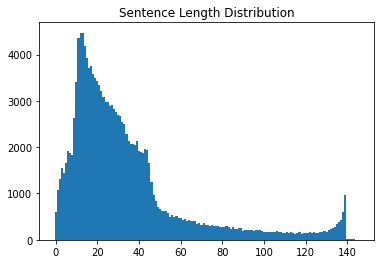

In [76]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### Tokenizing

In [77]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer


- 아래 작업엔 '`filtered_corpus`' 를 집어넣는다
- '`filtered_corpus`'를 파일로 출력 후 토크나이저 래퍼로 전달

In [ ]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean_nsmc_01.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in raw:
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_nsmc_spm_01 --vocab_size={}'.format(temp_file, vocab_size)    
)

In [79]:
!ls -l korean_nsmc_spm_*

-rw-r--r-- 1 root root 375903 Dec 12 06:52 korean_nsmc_spm_00.model
-rw-r--r-- 1 root root 145307 Dec 12 06:52 korean_nsmc_spm_00.vocab
-rw-r--r-- 1 root root 374659 Dec 12 07:27 korean_nsmc_spm_01.model
-rw-r--r-- 1 root root 144071 Dec 12 07:27 korean_nsmc_spm_01.vocab


In [94]:
s = spm.SentencePieceProcessor()
s.Load('korean_nsmc_spm_01.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1402, 10, 392, 15, 1329, 10, 123, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [95]:
s.DecodeIds([0])

' ⁇ '

In [96]:
s.DecodeIds([1])

''

In [97]:
s.DecodeIds([2])

''

In [100]:
s.DecodeIds([7999])

'탤'

In [99]:
s.DecodeIds([8000])

IndexError: Out of range: piece id is out of range.

In [101]:
model = "./korean_nsmc_spm_01.model"
vocab = "./korean_nsmc_spm_01.vocab"

def sp_tokenize(s, corpus, vocab): 
#     s = spm.SentencePieceProcessor()
#     s.Load(model)

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open(vocab, 'r') as f:
        voc = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(voc):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word


In [83]:
corpus_enc, tkn_idx, idx_tkn = sp_tokenize(s, raw, vocab)

In [ ]:
tkn_idx["<PAD>"] = vocab_size+0
tkn_idx["<BOS>"] = vocab_size+1
tkn_idx["<UNK>"] = vocab_size+2
tkn_idx["<EOS>"] = vocab_size+3
idx_tkn[vocab_size+0] = "<PAD>"
idx_tkn[vocab_size+1] = "<BOS>"
idx_tkn[vocab_size+2] = "<UNK>"
idx_tkn[vocab_size+3] = "<EOS>"

In [85]:
test_enc, tkn_idx, idx_tkn = sp_tokenize(s, test_raw, vocab)

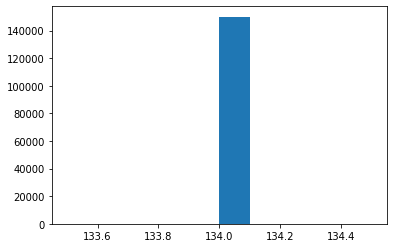

In [88]:
plt.hist([len(s) for s in corpus_enc])
plt.show()

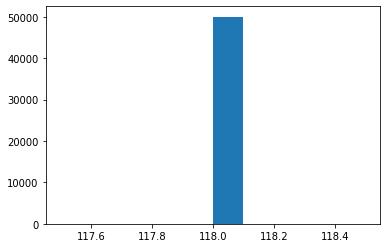

In [87]:
plt.hist([len(s) for s in test_enc])
plt.show()

- BOS, EOS 등 토큰 부재로 모델 학습 재시도
- 기존 함수를 그대로 썼을 시 SentencePiece 토크나이즈 후 패딩 최대 길이가 다르게 적용됨